In [1]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa
import time
from scipy.spatial import Delaunay
from scipy import interpolate

# enable autoreload
%load_ext autoreload
%autoreload 2
# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS


In [6]:
# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv")
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv")
df_test = pd.read_csv(f"{BASE_DIR}/test.csv")

columns = BEST_MODEL_COLUMNS

for item in columns:
    print(item, end=' ')

air2m_0 air1000_500_0 hgt500_0 hgt1000_0 omega500_0 pottemp1000-500_0 pottemp1000-850_0 pr_wtr_0 shum-uwnd-700_0 shum-uwnd-925_0 shum-vwnd-700_0 shum-vwnd-950_0 shum700_0 shum925_0 skt_0 slp_0 air2m_1 air1000_500_1 hgt500_1 hgt1000_1 omega500_1 pottemp1000-500_1 pottemp1000-850_1 pr_wtr_1 shum-uwnd-700_1 shum-uwnd-925_1 shum-vwnd-700_1 shum-vwnd-950_1 shum700_1 shum925_1 skt_1 slp_1 air2m_2 air1000_500_2 hgt500_2 hgt1000_2 omega500_2 pottemp1000-500_2 pottemp1000-850_2 pr_wtr_2 shum-uwnd-700_2 shum-uwnd-925_2 shum-vwnd-700_2 shum-vwnd-950_2 shum700_2 shum925_2 skt_2 slp_2 air2m_3 air1000_500_3 hgt500_3 hgt1000_3 omega500_3 pottemp1000-500_3 pottemp1000-850_3 pr_wtr_3 shum-uwnd-700_3 shum-uwnd-925_3 shum-vwnd-700_3 shum-vwnd-950_3 shum700_3 shum925_3 skt_3 slp_3 air2m_4 air1000_500_4 hgt500_4 hgt1000_4 omega500_4 pottemp1000-500_4 pottemp1000-850_4 pr_wtr_4 shum-uwnd-700_4 shum-uwnd-925_4 shum-vwnd-700_4 shum-vwnd-950_4 shum700_4 shum925_4 skt_4 slp_4 air2m_5 air1000_500_5 hgt500_5 hgt1

## LOOCV for 100 stations
The following codes runs LOOCV for 100 of randomly selected stations.
Since there are 101 feature variables, any station with less than or equal to 360 training samples are excluded.<br>
<b><i><u>Teaining dataset is different between lienar regression and XGBoost</u></i></b>
<ul>
    <li>Linear regression fits to samples from the specific station</li>
    <li>XGBoost fits to samples from all the stations</li>
</ul>
<b><i><u>Test dataset is THE SAME between lienar regression and XGBoost</u></i></b><br>
We use only the left-out station for computing the performance : Hence the performance comparison can be made directly for a specific station.

In [3]:
station_candidates = []
for name, group in df_train.groupby(by='name'):
    if group.shape[0] > 360:
        station_candidates.append(name)
np.random.seed(42)
stations = np.random.choice(station_candidates, size=100)
stations

array(['PUUKOHOLA HEIAU', 'FIELD 23', 'KAUKONAHUA MAUKA', 'HONOKAA MAUKA',
       'E KAUAI WATER 2', 'Pahoa Beacon', 'FIELD 27 (300)', 'PAIKO DRIVE',
       'HONOMU (1750)', 'POLIPOLI SPRING', 'KAHALUU', 'WAHIAWA MTN',
       'HANA AIRPORT', 'KAPOHO BEACH', '550', 'GAY 10', 'ONOULI (1600)',
       'PUUHINEI 1', 'KAUNALEWA', 'KEMOO CAMP', 'Makaha Country Club',
       'WAIEHU CAMP', 'FIELD 625', 'WAIAHI LOWER', 'MOKUAIKAUA RD',
       'WAIAHI LOWER', 'KUKUI', 'PUU ALALA', 'MAKAHA VALLEY', '549',
       'PUU KAPU RES 3', 'FIELD 4109', 'KAHANA 27', 'LAHAINA',
       'HOLUA CABIN', '542', 'GAGE 29', 'PANILEIHULU', 'KUKUIHAELE LANDG',
       'RESERVOIR 6', 'EKW 1 (120)', 'WAHIAWA MTN', 'KEMOO 3',
       'PANICUM FIELD', 'AIEA FIELD 84', 'FIELD B-8', 'Waiakoali Camp',
       'WHITMORE', 'KUKUIHAELE VILL', 'Makua Valley', 'KAIHULOA',
       'NUUANU RESERV 5', 'FIELD 401', 'FIELD 906 VIL 7', 'WAILUKU RIVER',
       'HALEPIULA 3', 'PUEHU RIDGE', 'KAPAKA', 'WAITA', 'HEADQUARTERS',
       'NEW FI

In [4]:
start = time.time()
results = []
for station in stations:
    df_train_station = df_train[df_train['name'] == station]
    df_test_station  = df_test[df_test['name'] == station]
    if df_train_station.shape[0] == 0 or df_test_station.shape[0] == 0:
        continue
    print("=========================================")
    print(f"Running experiment on {station} station.")
    print(f"There are:")
    print(f"{df_train_station.shape[0]} training data and")
    print(f"{df_test_station.shape[0]} test data")
    print("=========================================")

    # xgboost trains on the entire dataset
    Xtrain = np.array(df_train[columns].drop(labels=["data_in"], axis=1))
    Ytrain = np.array(df_train["data_in"])
    # test on the station data
    Xtest = np.array(df_test_station[columns].drop(labels=["data_in"], axis=1))
    Ytest = np.array(df_test_station["data_in"])

    # hyperparameters obtained by fine tuning
    xgboost = XGBRegressor(
        n_estimators=170,
        learning_rate=0.1,
        max_depth=9,
        verbosity=0
    )

    xgboost.fit(Xtrain, Ytrain)
    print("MSE on xgboost (test) : {:.5f}".format(mean_squared_error(Ytest, xgboost.predict(Xtest))))
    print("MSE on xgboost (train): {:.5f}".format(mean_squared_error(Ytrain, xgboost.predict(Xtrain))))
    mse_xgb = mean_squared_error(Ytest, xgboost.predict(Xtest))

    # linear regression trains on the station dataset
    Xtrain = np.array(df_train_station[columns].drop(labels=["data_in"], axis=1))
    Ytrain = np.array(df_train_station["data_in"])
    # test on the station data
    Xtest = np.array(df_test_station[columns].drop(labels=["data_in"], axis=1))
    Ytest = np.array(df_test_station["data_in"])

    model = LinearRegression()
    model.fit(Xtrain, Ytrain)
    print("MSE on Linear Regression (test) : {:.5f}".format(mean_squared_error(Ytest, model.predict(Xtest))))
    print("MSE on Linear Regression (train): {:.5f}".format(mean_squared_error(Ytrain, model.predict(Xtrain))))
    mse_linear = mean_squared_error(Ytest, model.predict(Xtest))
    
    results.append(
        {"n_samples": df_train_station.shape[0],
         "MSE_xgb": mse_xgb,
         "MSE_linear": mse_linear
        }
    )

sum_weighted_mse_xgb = 0
sum_weighted_mse_linear = 0
total_n_samples = 0
for item in results:
    total_n_samples += item["n_samples"]
    sum_weighted_mse_xgb += item["MSE_xgb"] * item["n_samples"] 
    sum_weighted_mse_linear += item["MSE_linear"] * item["n_samples"] 
    
mean_mse_xgb, mean_mse_linear = sum_weighted_mse_xgb/total_n_samples, sum_weighted_mse_linear/total_n_samples
print("mean of MSE with XGBoost: {:.5f}".format(mean_mse_xgb))
print("mean of MSE with Linear Regression: {:.5f}".format(mean_mse_linear))
    
end = time.time()
print(end - start)

Running experiment on PUUKOHOLA HEIAU station.
There are:
426 training data and
131 test data
MSE on xgboost (test) : 1.26395
MSE on xgboost (train): 4.65344
MSE on Linear Regression (test) : 1.60422
MSE on Linear Regression (train): 1.01516
Running experiment on FIELD 23 station.
There are:
450 training data and
135 test data
MSE on xgboost (test) : 9.01745
MSE on xgboost (train): 4.65344
MSE on Linear Regression (test) : 11.45782
MSE on Linear Regression (train): 12.17854
Running experiment on KAUKONAHUA MAUKA station.
There are:
450 training data and
135 test data
MSE on xgboost (test) : 14.16329
MSE on xgboost (train): 4.65344
MSE on Linear Regression (test) : 16.26509
MSE on Linear Regression (train): 7.72802
Running experiment on HONOKAA MAUKA station.
There are:
449 training data and
135 test data
MSE on xgboost (test) : 29.64510
MSE on xgboost (train): 4.65344
MSE on Linear Regression (test) : 24.83349
MSE on Linear Regression (train): 15.01859
Running experiment on E KAUAI WAT

In [6]:
print("weighted mean of MSE with XGBoost: {:.5f}".format(mean_mse_xgb))
print("weighted mean of MSE with Linear Regression: {:.5f}".format(mean_mse_linear))

weighted mean of MSE with XGBoost: 23.56847
weighted mean of MSE with Linear Regression: 23.40167


## Conclusion
Linear regression models works better with LOOCV for the chosen 100 random stations, when we are allowed to have as many model as the stations. </br>
However, the difference in MSE is within 2%. With such negligible difference, the result should be biased in favor of XGBoost for the following reasons.
<ol>
    <li>Only one model is necessary for XGBoost, whereas we need $\approx$ 1900 linear regression models.</li>
    <li>XGBoost can make prediction on locations where station does not exist, which would be impossible with linear regression. (Dicrete vs Continuous)</li>
    <li>Some stations do not have enough training data for linear regression (at least 100 samples), raising the necessity for hyperparameter tuning for regularization.</li>
</ol>

# Close look at specific stations, HILO, LIHUE, KALAE

In [10]:
station = "HILO"

df_train_station = df_train[df_train['name'] == station]
df_test_station  = df_test[df_test['name'] == station]

# xgboost trains on the entire dataset
Xtrain = np.array(df_train[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])
# test on the station data
Xtest = np.array(df_test_station[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test_station["data_in"])

# hyperparameters obtained by fine tuning
xgboost = XGBRegressor(
    n_estimators=170,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

xgboost.fit(Xtrain, Ytrain)
print("MSE on xgboost (test) : {:.5f}".format(mean_squared_error(Ytest, xgboost.predict(Xtest))))
print("MSE on xgboost (train): {:.5f}".format(mean_squared_error(Ytrain, xgboost.predict(Xtrain))))

# linear regression trains on the station dataset
Xtrain = np.array(df_train_station[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train_station["data_in"])
# test on the station data
Xtest = np.array(df_test_station[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test_station["data_in"])

model = LinearRegression()
model.fit(Xtrain, Ytrain)
print("MSE on Linear Regression (test) : {:.5f}".format(mean_squared_error(Ytest, model.predict(Xtest))))
print("MSE on Linear Regression (train): {:.5f}".format(mean_squared_error(Ytrain, model.predict(Xtrain))))

MSE on xgboost (test) : 36.22984
MSE on xgboost (train): 4.65344
MSE on Linear Regression (test) : 33.09867
MSE on Linear Regression (train): 24.18849


In [11]:
station = "LIHUE"

df_train_station = df_train[df_train['name'] == station]
df_test_station  = df_test[df_test['name'] == station]

# xgboost trains on the entire dataset
Xtrain = np.array(df_train[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])
# test on the station data
Xtest = np.array(df_test_station[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test_station["data_in"])

# hyperparameters obtained by fine tuning
xgboost = XGBRegressor(
    n_estimators=170,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

xgboost.fit(Xtrain, Ytrain)
print("MSE on xgboost (test) : {:.5f}".format(mean_squared_error(Ytest, xgboost.predict(Xtest))))
print("MSE on xgboost (train): {:.5f}".format(mean_squared_error(Ytrain, xgboost.predict(Xtrain))))

# linear regression trains on the station dataset
Xtrain = np.array(df_train_station[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train_station["data_in"])
# test on the station data
Xtest = np.array(df_test_station[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test_station["data_in"])

model = LinearRegression()
model.fit(Xtrain, Ytrain)
print("MSE on Linear Regression (test) : {:.5f}".format(mean_squared_error(Ytest, model.predict(Xtest))))
print("MSE on Linear Regression (train): {:.5f}".format(mean_squared_error(Ytrain, model.predict(Xtrain))))

MSE on xgboost (test) : 5.79774
MSE on xgboost (train): 4.65344
MSE on Linear Regression (test) : 6.01450
MSE on Linear Regression (train): 5.17918


In [13]:
station = "KALAE"

df_train_station = df_train[df_train['name'] == station]
df_test_station  = df_test[df_test['name'] == station]

# xgboost trains on the entire dataset
Xtrain = np.array(df_train[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])
# test on the station data
Xtest = np.array(df_test_station[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test_station["data_in"])

# hyperparameters obtained by fine tuning
xgboost = XGBRegressor(
    n_estimators=170,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

xgboost.fit(Xtrain, Ytrain)
print("MSE on xgboost (test) : {:.5f}".format(mean_squared_error(Ytest, xgboost.predict(Xtest))))
print("MSE on xgboost (train): {:.5f}".format(mean_squared_error(Ytrain, xgboost.predict(Xtrain))))

# linear regression trains on the station dataset
Xtrain = np.array(df_train_station[columns].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train_station["data_in"])
# test on the station data
Xtest = np.array(df_test_station[columns].drop(labels=["data_in"], axis=1))
Ytest = np.array(df_test_station["data_in"])

model = LinearRegression()
model.fit(Xtrain, Ytrain)
print("MSE on Linear Regression (test) : {:.5f}".format(mean_squared_error(Ytest, model.predict(Xtest))))
print("MSE on Linear Regression (train): {:.5f}".format(mean_squared_error(Ytrain, model.predict(Xtrain))))

MSE on xgboost (test) : 3.94315
MSE on xgboost (train): 4.65344
MSE on Linear Regression (test) : 5.24540
MSE on Linear Regression (train): 2.00699


# Is there relationship between the number of training data and the performance?
Run cross validation on all the stations as follows:
<ol>
    <li>Split data by station</li>
    <li>Train on that specific station and make prediction</li>
</ol>
We will run above experiment on linear regression and xgb
<hr>

In [8]:
df_combined = pd.concat([df_train, df_valid, df_test])

In [9]:
# linear regression
# make sure to groupby by skn: some stations have the same name e.g., WAIMEA
n_cv = 5
dfs = []

num_groups = df_combined['skn'].unique().shape[0]

for i, (name, group) in enumerate(df_combined.groupby(by="skn")):
    X = np.array(group[columns].drop("data_in", axis=1))
    Y = np.array(group["data_in"])
    if X.shape[0] < n_cv:
        group['prediction_multi_linear'] = [np.nan] * X.shape[0]
        continue
    
    yhat = cross_val_predict(LinearRegression(), X, Y, cv=n_cv, n_jobs=-1)
    rmse = mean_squared_error(Y, yhat, squared=False)
    
    group["prediction_multi_linear"] = yhat
    dfs.append(group)
    
    print(f"{i}/{num_groups}", end="\r")

In [10]:
df_multi_linear = pd.concat(dfs)
rmse = mean_squared_error(df_multi_linear['data_in'], df_multi_linear['prediction_multi_linear'], squared=False)
print("overall RMSE with Linear Regression: {:.3f} inch".format(rmse))

overall RMSE with Linear Regression: 5.134 inch


In [14]:
n_data_linear = []
rmse_per_station_linear = []
for name, group in df_multi_linear.groupby(by="skn"):
    rmse = mean_squared_error(group['data_in'], group['prediction_multi_linear'], squared=False)
    rmse_per_station_linear.append(rmse)
    n_data_linear.append(group.shape[0])

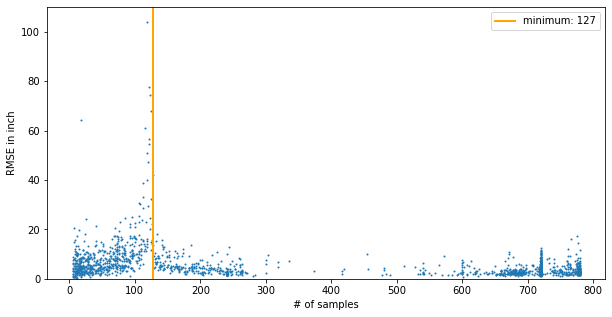

In [17]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.scatter(n_data_linear, rmse_per_station_linear, s=1)
# ax.set_ylim(0, 1000)
ax.axvline(x=127, color='orange', linewidth=2, label="minimum: 127")
ax.legend()
ax.set_xlabel("# of samples")
ax.set_ylabel("RMSE in inch")
ax.set_ylim((0, 110))
# ax.set_title("overall RMSE: {:.3f}, valid RMSE: ")
print()

In [22]:
ypred_xgb = np.genfromtxt(f"{BASE_DIR}/../codes/slurm/run_scripts/cross_val_predict/yperd.csv")
ytrue_xgb = np.genfromtxt(f"{BASE_DIR}/../codes/slurm/run_scripts/cross_val_predict/ytrue.csv")

mean_squared_error(ytrue_xgb, ypred_xgb, squared=False)

4.188593342149833

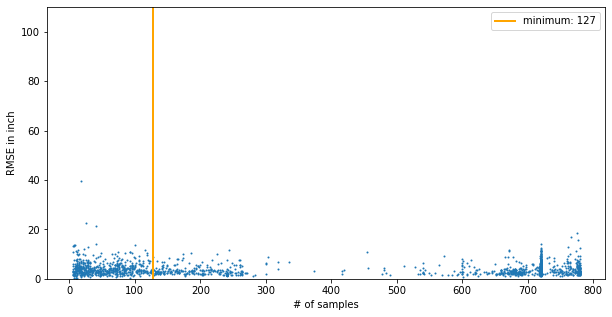

In [21]:
rmse_per_station_xgb = np.genfromtxt(f"{BASE_DIR}/../codes/slurm/run_scripts/cross_val_predict/rmse_per_station.csv")
n_data_xgb = np.genfromtxt(f"{BASE_DIR}/../codes/slurm/run_scripts/cross_val_predict/n_data.csv")

fig, ax = plt.subplots(1, figsize=(10,5))
ax.scatter(n_data_xgb, rmse_per_station_xgb, s=1)
# ax.set_ylim(0, 1000)
ax.axvline(x=127, color='orange', linewidth=2, label="minimum: 127")
ax.legend()
ax.set_xlabel("# of samples")
ax.set_ylabel("RMSE in inch")
ax.set_ylim((0,110))
# ax.set_title("overall RMSE: {:.3f}, valid RMSE: ")
print()

# test

In [2]:
df_multi_linear_ = pd.read_csv(f"{BASE_DIR}/cv/multi_linear.csv")

In [6]:
n_data_linear = []
rmse_per_station_linear = []
for name, group in df_multi_linear_.groupby(by="skn"):
    rmse = mean_squared_error(group['data_in'], group['prediction_multi_linear'], squared=False)
    rmse_per_station_linear.append(rmse)
    n_data_linear.append(group.shape[0])

In [8]:
rmse = mean_squared_error(df_multi_linear_['data_in'], df_multi_linear_['prediction_multi_linear'], squared=False)
print("overall RMSE with Linear Regression: {:.3f} inch".format(rmse))

overall RMSE with Linear Regression: 5.134 inch


In [10]:
df_multi_xgb_ = pd.read_csv(f"{BASE_DIR}/cv/multi_xgb.csv")
n_data_xgb = []
rmse_per_station_xgb = []
for name, group in df_multi_xgb_.groupby(by="skn"):
    rmse = mean_squared_error(group['data_in'], group['prediction_multi_linear'], squared=False)
    rmse_per_station_linear.append(rmse)
    n_data_xgb.append(group.shape[0])
rmse = mean_squared_error(df_multi_xgb_['data_in'], df_multi_xgb_['prediction_multi_linear'], squared=False)
print("overall RMSE with Linear Regression: {:.3f} inch".format(rmse))

overall RMSE with Linear Regression: 4.189 inch


# Can XGBoost make prediction on locations without stations? How smooth is it?# 

In [154]:
df_locations = pd.read_csv(f"{BASE_DIR}/SKNlocations.csv")

lon_oahu = (-157.966174-0.45, -157.966174+0.45)
lat_oahu = (21.485495-0.45, 21.485495+0.45)

df_locations_oahu = df_locations[
    (df_locations["Lat_DD"] < lat_oahu[1]) &
    (df_locations["Lat_DD"] > lat_oahu[0]) &
    (df_locations["Lon_DD"] < lon_oahu[1]) & 
    (df_locations["Lon_DD"] > lon_oahu[0])
]

station_coords_oahu = df_locations_oahu[["Lon_DD", "Lat_DD"]].to_numpy()

xmin, xmax = lon_oahu[0], lon_oahu[1]
ymin, ymax = lat_oahu[0], lat_oahu[1]

# calculate points on whicn predictions are made
hull = Delaunay(station_coords_oahu)
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 500), np.linspace(ymin, ymax, 500))
positions = np.dstack((xx.flatten(), yy.flatten())).reshape(-1,2)
idx_in = hull.find_simplex(positions)

positions_in = positions[np.where(idx_in > -1)[0]]

# prepare fake data
reanalysis_data = [
    'air2m', 'air1000_500', 'hgt500', 'hgt1000', 'omega500',
    'pottemp1000-500', 'pottemp1000-850', 'pr_wtr', 'shum-uwnd-700',
    'shum-uwnd-925', 'shum-vwnd-700', 'shum-vwnd-950', 'shum700', 'shum925', 
    'skt', 'slp'
]

columns_no_elevation = []
for i in range(6):
    for item in reanalysis_data:
        columns_no_elevation.append(f"{item}_{i}")

columns_no_elevation.extend(['data_in', 'lat', 'lon', 'season_wet', 'season_dry']) # "elevation" not included

# we will test on 1948 Jan
# remove all data from Jan. 1948 for training dataset.
# all data from Jan. 1948 is the test dataset
test_year, test_month = 1948, 1

df_combined = pd.concat([df_train, df_valid, df_test])
df_train = df_combined[(df_combined["year"] != test_year) & (df_combined["month"] != test_month)]
df_test = df_combined[(df_combined["year"] == test_year) & (df_combined["month"] == test_month)]

# synthesize test dataset
df_syn = pd.DataFrame([df_test[columns_no_elevation].iloc[0]] * positions_in.shape[0])
df_syn["lat"] = positions_in[:, 1]
df_syn["lon"] = positions_in[:, 0]

# convert to numpy
Xtrain = np.array(df_train[columns_no_elevation].drop(labels=["data_in"], axis=1))
Ytrain = np.array(df_train["data_in"])
Xtest = np.array(df_syn.drop(labels="data_in", axis=1))

# train the xgb model
xgboost = XGBRegressor(
    n_estimators=170,
    learning_rate=0.1,
    max_depth=9,
    verbosity=0
)

xgboost.fit(Xtrain, Ytrain)
print("training complete")

yhat_xgb = xgboost.predict(Xtest) * -1

# train the linear regression model
linear_regression = LinearRegression()
linear_regression.fit(Xtrain, Ytrain)
yhat_linear = linear_regression.predict(Xtest) * -1

# scale into (0, 1)
scaler = MinMaxScaler(feature_range=(0,1))
colors_xgb = scaler.fit_transform(yhat_xgb.reshape(-1,1))
colors_linear = scaler.fit_transform(yhat_linear.reshape(-1, 1))

training complete


In [156]:
# interpolate the actual data
df_test_oahu = pd.merge(left=df_locations_oahu, right=df_test, left_on="SKN", right_on="skn")
ytrue = np.array(df_test_oahu["data_in"]) * -1
colors_true = scaler.fit_transform(ytrue.reshape(-1, 1))

interp = interpolate.griddata(
    points=np.dstack((df_test_oahu["lon"], df_test_oahu["lat"])).reshape(-1,2),
    values=df_test_oahu["data_in"],
    xi=positions_in,
    method="linear",
    fill_value=0
) * -1
 
colors_interp = scaler.fit_transform(interp.reshape(-1, 1))

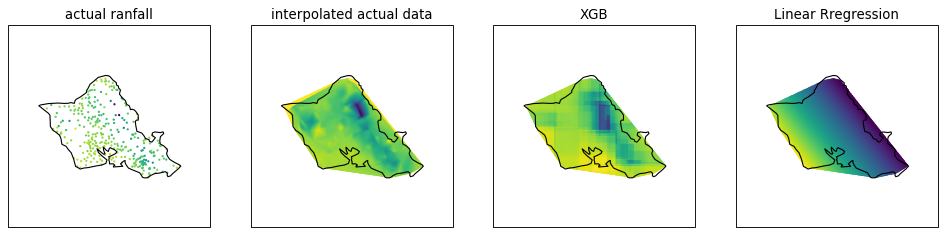

In [157]:
# Plot
fig, axs = plt.subplots(
    1, 4, figsize=(15, 10), dpi=80,
    subplot_kw={
        'projection': ccrs.PlateCarree(),
        'xlim': (xmin, xmax),
        'ylim': (ymin, ymax)
    },
)

axs[0].scatter(df_test_oahu["lon"], df_test_oahu["lat"], s=1, marker='o', c=colors_true)
axs[1].scatter(positions_in[:, 0], positions_in[:, 1], s=0.1, marker='o', c=colors_interp)
axs[2].scatter(positions_in[:, 0], positions_in[:, 1], s=0.1, marker='o', c=colors_xgb)
axs[3].scatter(positions_in[:, 0], positions_in[:, 1], s=0.1, marker='o', c=colors_linear)

axs[0].set_title('actual ranfall')
axs[1].set_title('interpolated actual data')
axs[2].set_title('single XGB')
axs[3].set_title('single Linear Rregression')

for ax in axs:
    ax.coastlines(resolution='10m')
    

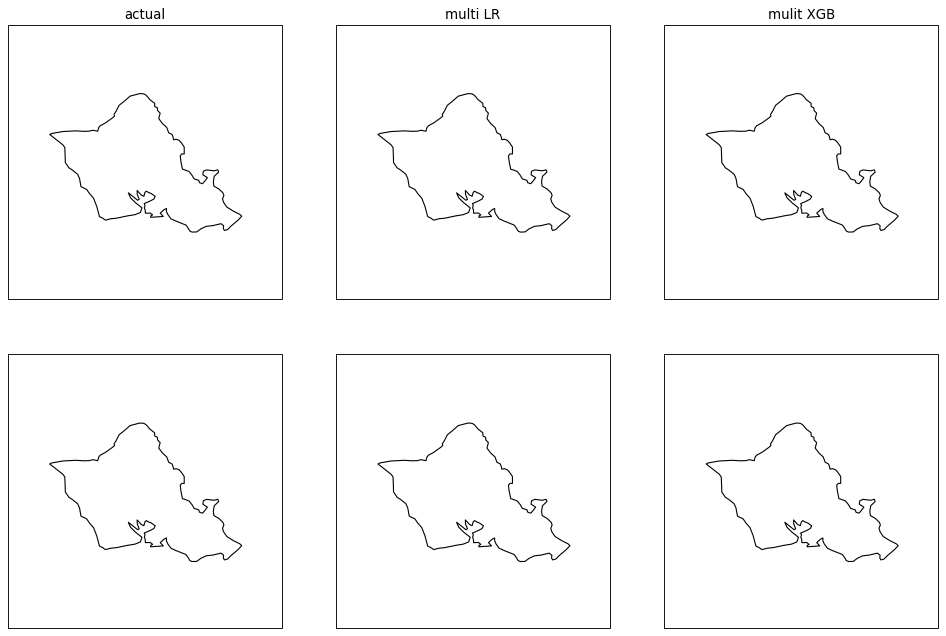

In [166]:
# actual


# Plot
fig, axs = plt.subplots(
    2, 3, figsize=(15, 10), dpi=80,
    subplot_kw={
        'projection': ccrs.PlateCarree(),
        'xlim': (xmin, xmax),
        'ylim': (ymin, ymax)
    },
)

# axs[0].scatter(df_test_oahu["lon"], df_test_oahu["lat"], s=1, marker='o', c=colors_true)
# axs[1].scatter(positions_in[:, 0], positions_in[:, 1], s=0.1, marker='o', c=colors_interp)
# axs[2].scatter(positions_in[:, 0], positions_in[:, 1], s=0.1, marker='o', c=colors_xgb)
# axs[3].scatter(positions_in[:, 0], positions_in[:, 1], s=0.1, marker='o', c=colors_linear)

# axs[0].set_title('actual ranfall')
# axs[1].set_title('interpolated actual data')
# axs[2].set_title('single XGB')
# axs[3].set_title('single Linear Rregression')

for ax in axs.flatten():
    ax.coastlines(resolution='10m')

axs[0, 0].set_title("actual")
axs[0, 1].set_title("multi LR")
axs[0, 2].set_title("mulit XGB")
print()
    


In [153]:
# XGBoost
# make sure to groupby by skn: some stations have the same name e.g., WAIMEA
ytrue = []
ypred = []

n_data = []
mse_per_station = []

n_cv = 5

num_groups = df_combined['skn'].unique().shape[0]

for i, (name, group) in enumerate(df_combined.groupby(by="skn")):
    X = np.array(group[columns].drop("data_in", axis=1))
    Y = np.array(group["data_in"])
    if X.shape[0] < n_cv: continue
        
    xgboost = XGBRegressor(
        n_estimators=170,
        learning_rate=0.1,
        max_depth=9,
        verbosity=0
    )

    
    yhat = cross_val_predict(xgboost, X, Y, cv=n_cv, n_jobs=-1)
    mse = mean_squared_error(Y, yhat, squared=False)
    
    ytrue.extend(Y)
    ypred.extend(yhat)
    
    n_data.append(X.shape[0])
    mse_per_station.append(mse)
    
    print(f"{i}/{num_groups}", end="\r")

KeyboardInterrupt: 